In [ ]:
!git clone https://github.com/bidulki/AIP8_sentimental_summary.git

In [ ]:
%cd AIP8_sentimental_summary

In [44]:
!pip install -r requirements.txt
from IPython.display import clear_output
clear_output()

In [43]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
import random
from utils.models import SentimentLSTM,Encoder, Decoder, Seq2Seq
from utils.datasets import SentimentalSummarizationDataset
from utils.vocab import Vocabulary
from utils.decode import decode

# Amazon review Dataset

In [48]:
!python preprocess.py --input_path data_raw/Reviews.csv --output_path data_preprocessed/reviews.tsv
data = pd.read_csv("data_preprocessed/reviews.tsv", sep="\t")
data = data.dropna()

max_text_len = 180
max_summary_len = 10

Text Cleaning...
  0%|                                                | 0/394987 [00:00<?, ?it/s]/home/bidulki/develop/AIP/AIP8_sentimental_summary/utils/text_utils.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text
100%|█████████████████████████████████| 394987/394987 [01:04<00:00, 6137.10it/s]
Summary Cleaning...
 16%|█████▏                           | 61706/394987 [00:03<00:17, 18956.54it/s]/home/bidulki/develop/AIP/AIP8_sentimental_summary/utils/text_utils.py:28: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text
100%|████████████████████████████████| 394987/394987 [00:21<00:00, 18725.51it/s]
Size of Text's Vocabulary: 131326
Size of Summa

# News Dataset

In [50]:
!python preprocess.py --input_path data_raw/news_summary.tsv --output_path data_preprocessed/news_summary.tsv  --input_encoding "UTF-8"
data = pd.read_csv("data_preprocessed/news_summary.tsv", sep="\t")
data = data.dropna()

max_text_len = 300
max_summary_len = 60

Text Cleaning...
100%|███████████████████████████████████| 98378/98378 [00:13<00:00, 7376.43it/s]
Summary Cleaning...
  0%|                                                 | 0/98378 [00:00<?, ?it/s]/home/bidulki/develop/AIP/AIP8_sentimental_summary/utils/text_utils.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text
100%|██████████████████████████████████| 98378/98378 [00:06<00:00, 16083.81it/s]
Size of Text's Vocabulary: 73788
Size of Summary's Vocabulary: 32200


## 데이터셋 설정

In [51]:
cleaned_text =np.array(data['Text'])
cleaned_summary=np.array(data['Summary'])
cleaned_score = np.array(data['Score'])

short_text = []
short_summary = []
short_score = []

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        short_score.append(cleaned_score[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary, 'score':short_score})

In [52]:
from sklearn.model_selection import train_test_split
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=0, shuffle=True)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=0, shuffle=True)

In [53]:
x_voc = Vocabulary(freq_threshold=4)
x_voc.build_vocabulary([text for text in df['text']])

y_voc = Vocabulary(freq_threshold=4)
y_voc.build_vocabulary([text for text in df['summary']])

train_dataset = SentimentalSummarizationDataset(train_data['text'].values, train_data['summary'].values, train_data['score'].values, x_voc, y_voc)
valid_dataset = SentimentalSummarizationDataset(valid_data['text'].values, valid_data['summary'].values, valid_data['score'].values, x_voc, y_voc)
test_dataset = SentimentalSummarizationDataset(test_data['text'].values, test_data['summary'].values, test_data['score'].values, x_voc, y_voc)

In [54]:
def pad_batch_tensors(batch_tensors, max_len, pad_token=0):
    padded_batch = [torch.nn.functional.pad(tensor, (0, max_len - tensor.size(0)), value=pad_token) 
                    for tensor in batch_tensors]
    return torch.stack(padded_batch).permute(1,0)

In [55]:
def collate_fn(batch):
    originals, summaries, labels = zip(*batch)
    originals_padded = pad_batch_tensors(originals, max_text_len, pad_token=x_voc.stoi["<PAD>"])
    summaries_padded = pad_batch_tensors(summaries, max_summary_len, pad_token=y_voc.stoi["<PAD>"])
    labels = torch.stack(labels)
    
    return originals_padded, summaries_padded, labels

In [56]:
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

## 학습 코드

In [57]:
def train(model_summary, model_sentiment, iterator, optimizer_summary, optimizer_sentiment, criterion_summary, criterion_sentiment, clip, device):
    model_summary.train()
    model_sentiment.train()
    epoch_loss = 0
    for i, batch in enumerate(tqdm(iterator)):
        src, trg, label = batch
        src, trg, label = src.to(device), trg.to(device), label.to(device)
        label = label.squeeze()
        optimizer_sentiment.zero_grad()
        output_sentiment = model_sentiment(src)
        loss_sentiment = criterion_sentiment(output_sentiment, label)
        loss_sentiment.backward()
        torch.nn.utils.clip_grad_norm_(model_sentiment.parameters(), clip)
        optimizer_sentiment.step()

        optimizer_summary.zero_grad()
        with torch.no_grad():
            sentiment_hidden = model_sentiment.hidden(src)
        output = model_summary(src, trg, sentiment_hidden)
        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)

        loss_summary = criterion_summary(output, trg)
        loss_summary.backward()

        torch.nn.utils.clip_grad_norm_(model_summary.parameters(), clip)

        optimizer_summary.step()

        epoch_loss += loss_summary.item()

    return epoch_loss / len(iterator)

In [58]:
def evaluate(model_summary, model_sentiment, iterator, criterion_summary, device):
    model_summary.eval()
    model_sentiment.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(iterator)):
            src, trg, label = batch
            src, trg, label = src.to(device), trg.to(device), label.to(device)
            label = label.squeeze()
            sentiment_hidden = model_sentiment.hidden(src)
            output = model_summary(src, trg, sentiment_hidden, 0)

            output_dim = output.shape[-1]
            output = output[1:].reshape(-1, output_dim)
            trg = trg[1:].reshape(-1)

            loss = criterion_summary(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = len(x_voc)
output_dim = len(y_voc)
encoder = Encoder(input_dim, 256, 512, 2, 0.5)
decoder = Decoder(output_dim, 256, 512, 2, 0.5)
model_summary = Seq2Seq(encoder, decoder, device, sentiment_ratio=0.2).to(device)

optimizer_summary = optim.Adam(model_summary.parameters())
pad_idx = y_voc.stoi["<PAD>"]
criterion_summary = nn.CrossEntropyLoss(ignore_index=pad_idx)

model_sentiment = SentimentLSTM(input_dim, 256, 512, 5, 2, 0.5).to(device)
optimizer_sentiment = optim.Adam(model_sentiment.parameters())
criterion_sentiment = nn.CrossEntropyLoss()

100%|██████████| 17/17 [00:04<00:00,  3.69it/s]


Epoch: 01
	Train Loss: 7.190
	 Val. Loss: 7.050


100%|██████████| 17/17 [00:04<00:00,  3.68it/s]


Epoch: 02
	Train Loss: 7.007
	 Val. Loss: 7.057


100%|██████████| 17/17 [00:04<00:00,  3.70it/s]


Epoch: 03
	Train Loss: 6.935
	 Val. Loss: 7.065


100%|██████████| 17/17 [00:04<00:00,  3.61it/s]


Epoch: 04
	Train Loss: 6.822
	 Val. Loss: 6.904


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch: 05
	Train Loss: 6.553
	 Val. Loss: 6.694


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


Epoch: 06
	Train Loss: 6.280
	 Val. Loss: 6.476


100%|██████████| 17/17 [00:04<00:00,  3.65it/s]


Epoch: 07
	Train Loss: 6.042
	 Val. Loss: 6.354


100%|██████████| 17/17 [00:04<00:00,  3.61it/s]


Epoch: 08
	Train Loss: 5.842
	 Val. Loss: 6.238


100%|██████████| 17/17 [00:04<00:00,  3.85it/s]


Epoch: 09
	Train Loss: 5.692
	 Val. Loss: 6.167


100%|██████████| 17/17 [00:04<00:00,  3.74it/s]

Epoch: 10
	Train Loss: 5.554
	 Val. Loss: 6.080


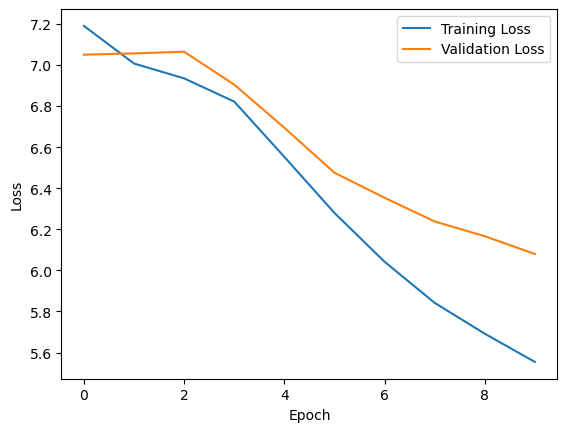

100%|██████████| 17/17 [00:04<00:00,  3.63it/s]

Test Loss: 6.046


In [60]:
import matplotlib.pyplot as plt

num_epochs = 10
clip = 1

train_loss_list = []
valid_loss_list = []

for epoch in range(num_epochs):
    train_loss = train(model_summary=model_summary, model_sentiment=model_sentiment, iterator=train_loader,\
                    optimizer_summary=optimizer_summary, optimizer_sentiment=optimizer_sentiment, \
                    criterion_summary=criterion_summary, criterion_sentiment=criterion_sentiment, clip=clip, device=device)
    valid_loss = evaluate(model_summary=model_summary, model_sentiment=model_sentiment, iterator=valid_loader, \
                    criterion_summary=criterion_summary, device=device)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

plt.plot(train_loss_list, label='Training Loss')
plt.plot(valid_loss_list, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


test_loss = evaluate(model_summary=model_summary, model_sentiment=model_sentiment, iterator=test_loader, \
                criterion_summary=criterion_summary, device=device)

print(f'Test Loss: {test_loss:.3f}')

In [61]:
# decode
decoded_sentences, trg_list=decode(model_summary=model_summary, model_sentiment=model_sentiment, iterator=test_loader, \
                device=device)

In [62]:
# rouge
rouge_1_scores = []
rouge_2_scores = []
rouge_l_scores = []
rouge = Rouge()

for i in range(len(decoded_sentences)):
  if decoded_sentences[i]!='' and trg_list[i]!='':
    scores = rouge.get_scores(decoded_sentences[i], trg_list[i], avg=True)
    rouge_1_scores.append(scores['rouge-1']['f'])
    rouge_2_scores.append(scores['rouge-2']['f'])
    rouge_l_scores.append(scores['rouge-l']['f'])

rouge_1_score = sum(rouge_1_scores) / len(rouge_1_scores)
rouge_2_score = sum(rouge_2_scores) / len(rouge_2_scores)
rouge_l_score = sum(rouge_l_scores) / len(rouge_l_scores)

print("Rouge-1 Score:", rouge_1_score)
print("Rouge-2 Score:", rouge_2_score)
print("Rouge-L Score:", rouge_l_score)

In [64]:
# cross_validation

from sklearn.model_selection import train_test_split, KFold, ParameterSampler

# Concatenate train_data and valid_data for cross-validation
combined_data = pd.concat([train_data, valid_data])

# Hyperparameter grid and K-Fold setup
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
param_grid = {'sentiment_ratio': np.arange(0.0, 1.1, 0.1)}
param_list = list(ParameterSampler(param_grid, n_iter=len(param_grid['sentiment_ratio'])))

best_avg_rouge_score = 0
best_model_params = None

# Cross-validation and Hyperparameter Tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
clip = 1
rouge = Rouge()

for params in param_list:
    avg_rouge_score = 0
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_data)):
        # Split train_data into training and validation for current fold
        fold_train_data = combined_data.iloc[train_idx]
        fold_valid_data = combined_data.iloc[valid_idx]

        fold_train_dataset = SentimentalSummarizationDataset(fold_train_data['text'].values, fold_train_data['summary'].values, fold_train_data['score'].values, x_voc, y_voc)
        fold_valid_dataset = SentimentalSummarizationDataset(fold_valid_data['text'].values, fold_valid_data['summary'].values, fold_valid_data['score'].values, x_voc, y_voc)

        fold_train_loader = DataLoader(fold_train_dataset, batch_size=batch_size, collate_fn=collate_fn)
        fold_valid_loader = DataLoader(fold_valid_dataset, batch_size=batch_size, collate_fn=collate_fn)

        # Initialize models for current fold
        model_summary = Seq2Seq(encoder, decoder, device, params['sentiment_ratio']).to(device)
        model_sentiment = SentimentLSTM(input_dim, 256, 512, 5, 2, 0.5).to(device)

        optimizer_summary = optim.Adam(model_summary.parameters())
        optimizer_sentiment = optim.Adam(model_sentiment.parameters())
        criterion_summary = nn.CrossEntropyLoss(ignore_index=pad_idx)
        criterion_sentiment = nn.CrossEntropyLoss()

        # Training and Validation for the current fold
        for epoch in range(num_epochs):
            train_loss = train(model_summary=model_summary, model_sentiment=model_sentiment, iterator=fold_train_loader,\
                            optimizer_summary=optimizer_summary, optimizer_sentiment=optimizer_sentiment, \
                            criterion_summary=criterion_summary, criterion_sentiment=criterion_sentiment, clip=clip, device=device)
            valid_loss = evaluate(model_summary=model_summary, model_sentiment=model_sentiment, iterator=fold_valid_loader, \
                            criterion_summary=criterion_summary, device=device)

            print(f'Epoch: {epoch+1:02}')
            print(f'\tTrain Loss: {train_loss:.3f}')
            print(f'\t Val. Loss: {valid_loss:.3f}')

        # Decoding and computing ROUGE scores
        decoded_sentences, trg_list = decode(model_summary, model_sentiment, fold_valid_loader, device)
        rouge_scores = [rouge.get_scores(dec, ref, avg=True) for dec, ref in zip(decoded_sentences, trg_list) if dec != '' and ref != '']
        fold_avg_rouge_l = np.mean([score['rouge-l']['f'] for score in rouge_scores])
        avg_rouge_score += fold_avg_rouge_l / n_splits

    print(f'Hyperparameters: {params}, Average ROUGE-L Score: {avg_rouge_score:.3f}')

    if avg_rouge_score > best_avg_rouge_score:
        best_avg_rouge_score = avg_rouge_score
        best_model_params = params

print(f'Best Hyperparameters: {best_model_params}, Best Average ROUGE-L Score: {best_avg_rouge_score:.3f}')

In [63]:
# output_file = "result/review_0.2.tsv"
# new_df = pd.DataFrame()
# new_df['original'] = trg_list
# new_df['summary'] = decoded_sentences
# new_df.to_csv(output_file, index=False, sep="\t")